# Project: Portfolio Optimization with Historical Stock Data using Mean-Variance Optimization and Efficient Frontier

The goal of this project is to build an optimized portfolio using historical stock data. We'll use quantitative methods to maximize returns and minimize risk, employing techniques like Mean-Variance Optimization and the Efficient Frontier.

# 1. Importing libraries and data collection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

Decide on the number of stocks you want to include in your portfolio. For this example, let's select the following stocks:

1. Apple (AAPL)
2. Microsoft (MSFT)
3. Amazon (AMZN)
4. Google (GOOGL)
5. Tesla (TSLA)

The historical data for these stocks is being extracted from a reliable source https://finance.yahoo.com

In [16]:
# Defining the stock tickers
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']

# Downloading data from Yahoo Finance
data = yf.download(tickers, start='2020-01-01', end='2024-08-01')['Adj Close']


[*********************100%%**********************]  5 of 5 completed


# 2. Data Preparation

It is important to understand the volatility of these stocks through percentage change because returns, not prices, are the standard way to measure the relative change in a stock's value over time. Hence, we will use the method of percentage change to know this.

By converting price changes to percentage changes, we normalize the data, allowing for a fair comparison of how much each stock has increased or decreased relative to its own price.

In [17]:
# Calculating daily returns
returns = data.pct_change().dropna()


In [18]:
# Checking for missing data
print(returns.isnull().sum())

# Dropping rows with missing values
returns.dropna(inplace=True)


Ticker
AAPL     0
AMZN     0
GOOGL    0
MSFT     0
TSLA     0
dtype: int64


# 3. Exploratory Data Analysis

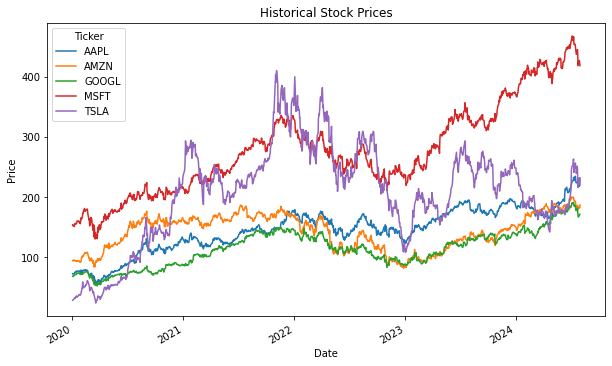

In [19]:
# Plotting stock prices
data.plot(figsize=(10, 6))
plt.title('Historical Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


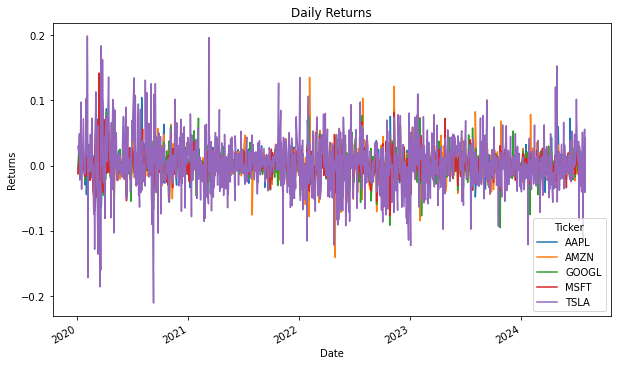

In [20]:
# Plotting daily returns
returns.plot(figsize=(10, 6))
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()


**Key Observations from Historical Stock Prices and Daily Returns plot:**

1. The chart shows considerable fluctuations in daily returns, particularly at the beginning of the observed period (2020). This aligns with the onset of the COVID-19 pandemic, which caused significant market volatility. As the timeline progresses towards 2021 and 2022, the fluctuations appear to stabilize slightly, indicating periods of relative market calm compared to the initial shock of the pandemic.

2. Tesla (TSLA) appears to have more pronounced spikes in daily returns, reflecting its higher volatility relative to the other stocks. This could be attributed to Tesla’s history of significant price swings due to various factors like product announcements, regulatory news, or earnings reports.

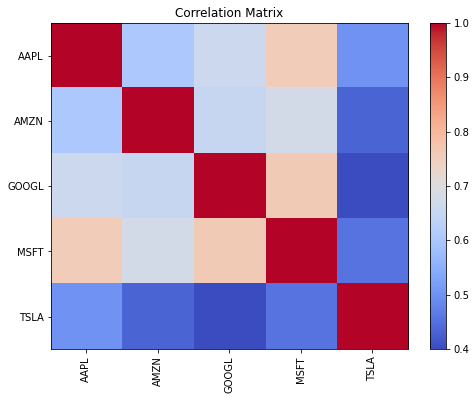

In [21]:
# Calculating the correlation matrix
corr_matrix = returns.corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title('Correlation Matrix')
plt.show()


The **correlation matrix** is a crucial matrix in portfolio management. Investors seeking diversification aim to combine assets that are not highly correlated, as this reduces portfolio risk. In this context, Tesla’s lower correlations with the other stocks suggest it might provide some diversification benefits within a tech-heavy portfolio.

# 4. Portfolio Optimization

We will create some user defined functions to optimize portfolio of assets by maximizing the risk-adjusted return, typically measured by the Sharpe ratio. This process will involve calculating key metrics such as portfolio return, portfolio volatility and Sharpe ratio. We will use these matrics to find the optimal combination of asset weights that will help us yeild the best performance relative to risk. 

**Portfolio Performance:**

The user defined function 'Portfolio performance' is computing two matrics - expected annual return and the annualized volatility of a portfolio, based on the provided asset weight and historical returns. It uses the following mathematical formula to compute portfolio return and portfolio volatility.

$$
\text{Portfolio Return} = \left( \sum_{i=1}^{n} w_i \times \mu_i \right) \times 252
$$


**Portfolio Volatility (Standard Deviation):**

Volatility represents the degree of variation in the portfolio's returns over time. It is a key indicator of risk. This parameter of the portfolio measures the risk of uncertainity associated with the portfolio's returns. 

$$
\text{Portfolio Volatility} = \sqrt{w^T \sum w}
$$

We are aiming to get the daily volatility. Hence the formula for Portfolio Volatility will be multiplied by square root of 252 (actual trading days in the year).

$$
\text{Portfolio Volatility} = \sqrt{w^T \sum w} \times \sqrt{252}
$$

**Adjusted Risk Return:**

We will use the negative Sharpe ratio of the portfolio to calculate adjusted risk return. The Sharpe ratio measures the risk adjusted return of the portfolio. The negative sign is applied because the optimization algorithms typically minimizes it, so by minimizing the negative Sharpe ratio, we are effectively maximizing the Sharpe ratio.

$$
\text{Negative Sharpe Ratio} = - \frac{\text{Portfolio Return} - \text{Risk Free Rate}}{\text{Portfolio Volatility}}
$$


In [22]:
# Defining the portfolio performance functions

def portfolio_performance(weights, returns):
    # Calculating portfolio return and standard deviation
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_std

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.04):
    # Calculating negative Sharpe Ratio
    p_return, p_std = portfolio_performance(weights, returns)
    return -(p_return - risk_free_rate) / p_std

def portfolio_volatility(weights, returns):
    # Calculating portfolio volatility
    return portfolio_performance(weights, returns)[1]


After the user defined functions are set, we will have to set up an optimization algorithm so to define feasible region in which the solution (optimal portfolio weights) must lie. The optimizer will adjust the initial weights to find the optimal allocation that maximizes the objective function (like Sharpe ratio), without violating other constraints and bounds provided.

**Constraints** ensures that the sum of weights of all assets in the portfolio equals 1.

**Bounds** specify allowable range for each asset's weight in the portfolio. In this 
case, each weight mustbe between 0 and 1.

**Initial weights** sets up an initial guess for the weights of the assets in the 
portfolio. This is essential for the optimization algorithm to start the process.


In [30]:
# Setting the constraints and bounds for optimization
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))
initial_weights = np.array(len(tickers) * [1.0 / len(tickers)])

We are using the 'minimize' function to adjust weights to minimize the negative Sharpe ratio while respecting the bounds and constraints. The result is an optimized set of weights that should corresponds to the maximum Sharpe ratio.

In [31]:
"""

We are using the SLSQP (Sequential Least Squares Programming) optimization algorithm in this process.
This algorithm is a common method used for constrained optimization. It is particularly well suited 
for the problems where you need to optimize a function subject to both equality and inequality constraints.

"""

# Minimizing the negative Sharpe Ratio
opt_results = minimize(negative_sharpe_ratio, initial_weights, args=(returns,),
                       method='SLSQP', bounds=bounds, constraints=constraints)

# Getting the optimal weights
tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
optimal_weights = opt_results.x
for ticker, weight in zip(tickers, optimal_weights):
    print(f'{ticker}: {weight:.4f}')

AAPL: 0.3224
GOOGL: 0.0000
MSFT: 0.1299
AMZN: 0.1807
TSLA: 0.3670


# 5. Constructing the Efficient Frontier

In this stage, we will calculate portfolio returns and volatility for a range of weights to construct the efficient frontier. The Efficient Frontier is supposed to represent a set of optimal portfolios that offer the highest expected return for a defined level of risk (here, volatility) or lowest risk for a given level of expected return.

This code is generating large number of random portfolios with different combination of asset weights. For each portfolio, expected return, volatility and Sharpe ratio is calculated.

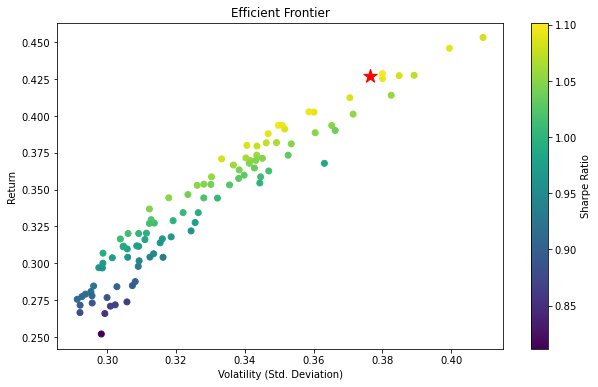

In [25]:
"""

These lines of code are generating random weights for each asset, ensuring that the sum of the weights
equals 1 (fully invested portfolio). Calculating the expected return and volatility for each portfolio
using the same methods as in earlier section. And calculating the Sharpe ratio for each portfolio to 
measure its risk-adjusted return using the same methods as in earlier section.

"""

def efficient_frontier(returns, num_portfolios=100):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    for i in range(num_portfolios):
        # Randomly generate weights
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        
        # Calculate portfolio performance
        portfolio_return, portfolio_std = portfolio_performance(weights, returns)
        
        # Store the results
        results[0,i] = portfolio_std
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - 0.04) / portfolio_std  # Sharpe Ratio
    
    return results, weights_record

# Generating the efficient frontier
results, weights_record = efficient_frontier(returns)



"""

After the simulation of portfolios, the code is identifying the portfolio that is lying on the Efficient
Frontier plot. The plot will highlight the most optimal portfolio (one with the highest Sharpe ratio) 
on the plot.

"""


# Plotting the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(portfolio_volatility(optimal_weights, returns), 
            portfolio_performance(optimal_weights, returns)[0],
            c='red', marker='*', s=200)  # Mark the optimal portfolio
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Return')
plt.show()


# 6. Analysis of Optimized Portfolio

Here we will calculate the expected return, volatility and Sharpe ratio of the optimized portfolio, and visualize the portfolio with the help of pie chart.

In [26]:
# Calculating expected return, volatility, and Sharpe ratio of the optimized portfolio
opt_return, opt_volatility = portfolio_performance(optimal_weights, returns)
opt_sharpe_ratio = (opt_return - 0.04) / opt_volatility

print(f'Optimized Portfolio Return: {opt_return:.2f}')
print(f'Optimized Portfolio Volatility: {opt_volatility:.2f}')
print(f'Optimized Portfolio Sharpe Ratio: {opt_sharpe_ratio:.2f}')


Optimized Portfolio Return: 0.43
Optimized Portfolio Volatility: 0.38
Optimized Portfolio Sharpe Ratio: 1.11


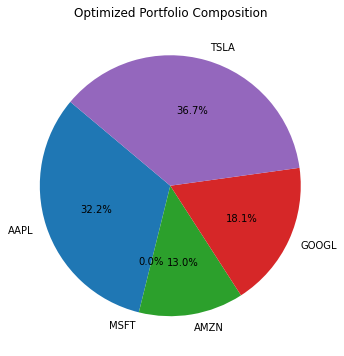

In [27]:
# Visualizing the composition of the optimized portfolio
plt.figure(figsize=(10, 6))
plt.pie(optimal_weights, labels=tickers, autopct='%1.1f%%', startangle=140)
plt.title('Optimized Portfolio Composition')
plt.show()


The optimized portfolio composition shows the percentage of total investment that is supposed to be allocated to each stock in the portfolio. 

# 7. Limitations

**1. Historical Data**

The project relies completely on historical returns, based on the assumption that past performance will predict future returns. Market conditions can change with respect to time, resulting in making historical data less relavent.

The method assumes that the statistical properties of asset returns (mean, varience, covariance) are stable and not dynamic, which is not a case in real markets.

**2. Mean-Variance Optimization (Modern Portfolio Theory)**

The optimization assumes that asset returns are normally distributed, which may not be true. In reality, returns can be skewed.

The analysis considers only a single time period (from 2020 to August 2024) and does not account for dynamic nature of markets over multiple periods.

**3. Numerical Assumptions**

The Sharpe ratio calculation assumes a constant risk rate (i.e. 4%), which may not hold true in all economic conditions.

The Sharpe ratio only considers volatility as a measure of risk, ignoring other types of risks.

# 8. Further Improvisations

Please note - Since this is a series of project for personal learning, I, the author, am focusing on using more statistical and mathematical approach of improvisations in the project. Hence, we will discuss the technical ways in which we can improvise the results and make a comparison in various ways in the future.

**1. Dynamic Risk-Free Rate**

Instead of using a constant risk-free rate (e.g., 4%), we can incorporate a dynamic risk-free rate based on current market conditions.

**2. Alternative Optimization Techniques**

Exploring other optimization techniques beyond Mean-Varience Optimizations, like Black-Litterman Model and Heirarchical Risk Parity (HRP).

**3. Using Monte Carlo Simulations**

Performing Monte Carlo simulations will help the model explore wider range of portfolio scenarios. This will also help in understing how different portfolio allocations will perform under variety of market conditions, and also combining the above 2 improvisations.